In [2]:
!pip install -q transformers==4.37.2
!pip install bitsandbytes==0.41.3 accelerate==0.25.0
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q gradio
!pip install -q gTTS

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
import torch
from transformers import BitsAndBytesConfig, pipeline

In [3]:
quant_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_compute_dtype = torch.float16
)

In [4]:
model_id = "llava-hf/llava-1.5-7b-hf"

In [5]:
pipe = pipeline(
    "image-to-text",
    model = model_id,
    model_kwargs = {"quantization_config": quant_config}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

In [7]:
import whisper
import gradio as gr
import time
import warnings
import os
from PIL import Image
from gtts import gTTS

In [8]:
pipe

In [9]:
image_path = "me.jpg"

In [10]:
image = Image.open(image_path)

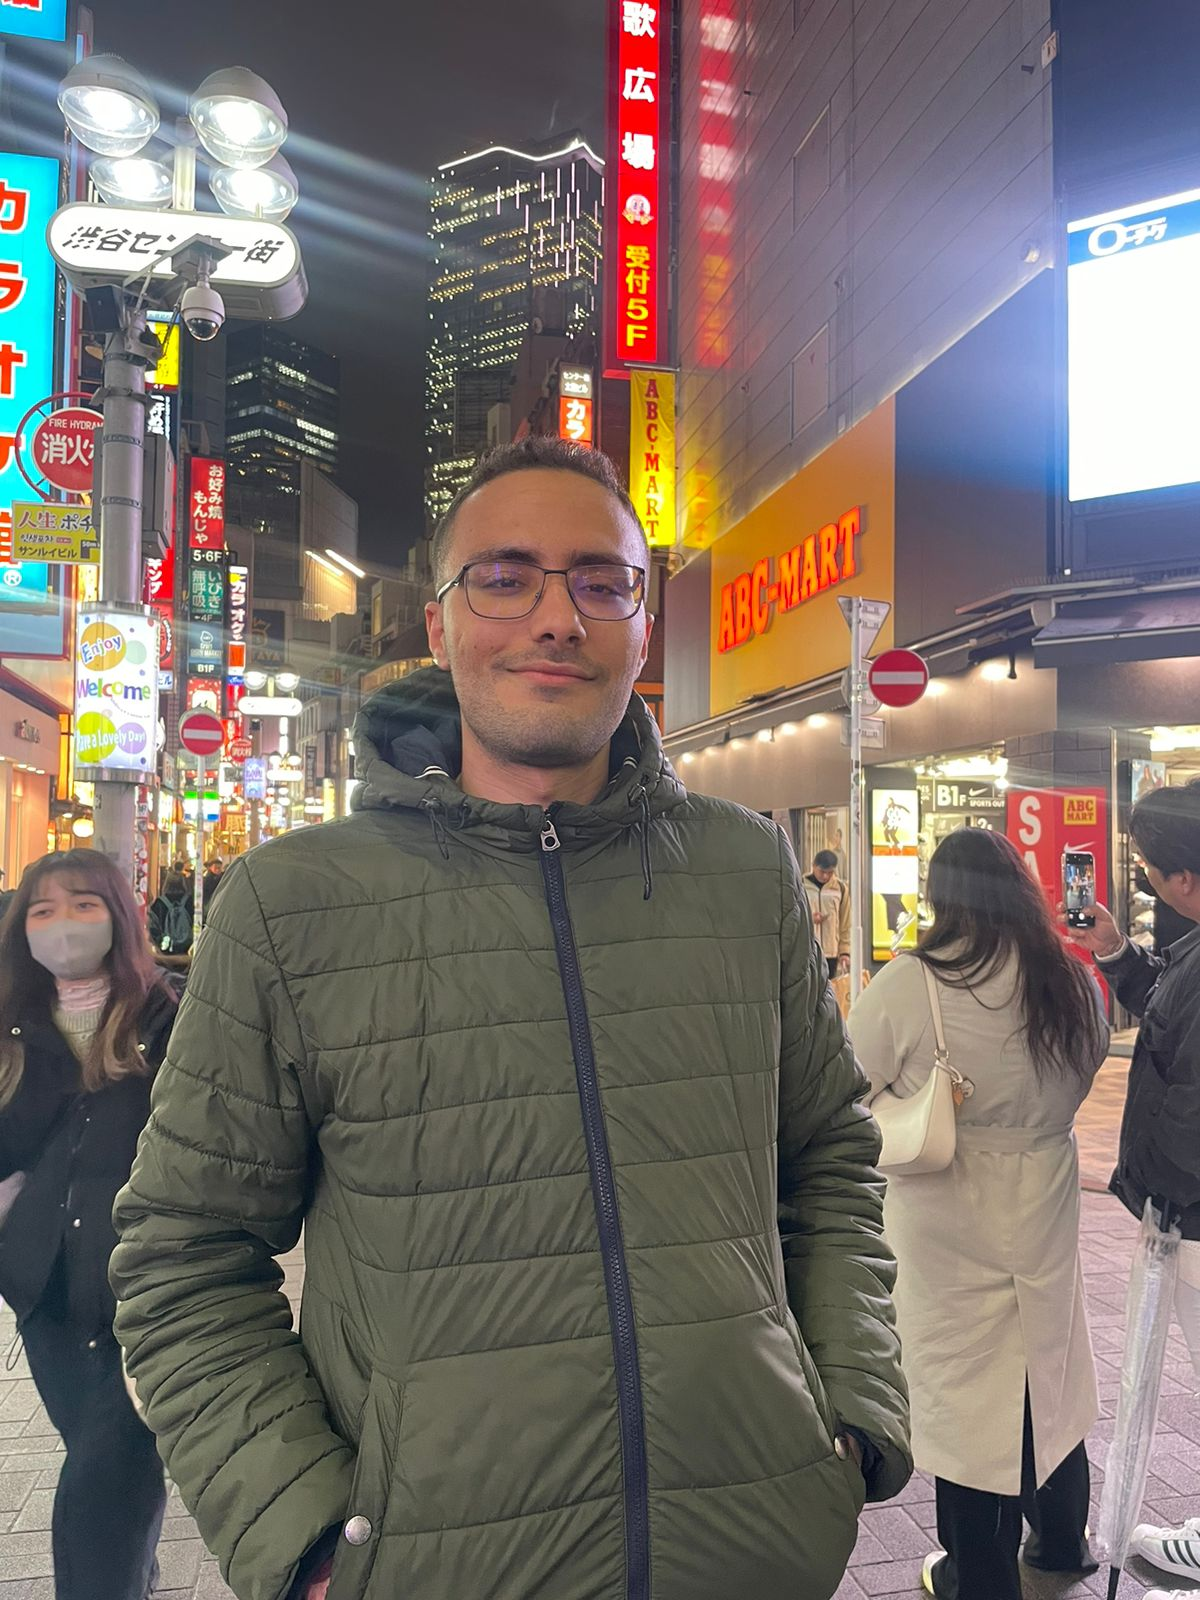

In [11]:
image

In [12]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
max_new_tokens = 250

In [14]:
prompt_instructions = """
You are a helpful AI assistant who is able to answer questions about the image, describe the image in detail.
"""

In [15]:
prompt = "User <image>\n" + prompt_instructions + "\nAssisstant:"

In [17]:
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": max_new_tokens})

In [18]:
outputs

[{'generated_text': 'User  \n\nYou are a helpful AI assistant who is able to answer questions about the image, describe the image in detail.\n\nAssisstant: The image features a man wearing glasses and a green jacket, standing in a crowded city street. He is smiling and appears to be enjoying the bustling atmosphere. There are several other people in the scene, some of them carrying handbags. The street is lined with various businesses, including a store with a sign on it. The overall scene is lively and full of activity.'}]

In [19]:
for sent in sent_tokenize(outputs[0]["generated_text"]):
    print(sent)

User  

You are a helpful AI assistant who is able to answer questions about the image, describe the image in detail.
Assisstant: The image features a man wearing glasses and a green jacket, standing in a crowded city street.
He is smiling and appears to be enjoying the bustling atmosphere.
There are several other people in the scene, some of them carrying handbags.
The street is lined with various businesses, including a store with a sign on it.
The overall scene is lively and full of activity.


In [20]:
warnings.filterwarnings("ignore")

In [21]:
import numpy as np

In [22]:
torch.cuda.is_available()

True

In [23]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
print(f"Using Torch {torch.__version__} {DEVICE}")

Using Torch 2.4.1+cu121 cuda


In [25]:
model = whisper.load_model("medium", device=DEVICE)

100%|█████████████████████████████████████| 1.42G/1.42G [00:29<00:00, 51.6MiB/s]


In [26]:
import re
import datetime

In [28]:
tstamp = datetime.datetime.now()
tstamp = str(tstamp).replace(" ", "_")

logfile = f"log_{tstamp}.txt"

In [29]:
def writehistory(text):
  with open(logfile, "a", encoding='utf-8') as f:
    f.write(text)
    f.write("\n")
  f.close()

In [30]:
import requests

In [31]:
def img2txt(input_text, input_image):

    # load the image
    image = Image.open(input_image)

    writehistory(f"Input text: {input_text} - Type: {type(input_text)} - Dir: {dir(input_text)}")
    if type(input_text) == tuple:
        prompt_instructions = """
        Describe the image using as much detail as possible, is it a painting, a photograph, what colors are predominant, what is the image about?
        """
    else:
        prompt_instructions = """
        Act as an expert in imagery descriptive analysis, using as much detail as possible from the image, respond to the following prompt:
        """ + input_text

    writehistory(f"prompt_instructions: {prompt_instructions}")
    prompt = "USER: <image>\n" + prompt_instructions + "\nASSISTANT:"

    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

    # Properly extract the response text
    if outputs is not None and len(outputs[0]["generated_text"]) > 0:
        match = re.search(r'ASSISTANT:\s*(.*)', outputs[0]["generated_text"])
        if match:
            # Extract the text after "ASSISTANT:"
            reply = match.group(1)
        else:
            reply = "No response found."
    else:
        reply = "No response generated."

    return reply

In [32]:
def transcribe(audio):

    # Check if the audio input is None or empty
    if audio is None or audio == '':
        return ('','',None)  # Return empty strings and None audio file

    # language = 'en'

    audio = whisper.load_audio(audio)
    audio = whisper.pad_or_trim(audio)

    mel = whisper.log_mel_spectrogram(audio).to(model.device)

    _, probs = model.detect_language(mel)

    options = whisper.DecodingOptions()
    result = whisper.decode(model, mel, options)
    result_text = result.text

    return result_text

In [33]:
def text_to_speech(text, file_path):
    language = 'en'

    audioobj = gTTS(text = text,
                    lang = language,
                    slow = False)

    audioobj.save(file_path)

    return file_path

In [35]:
import locale

print(locale.getlocale())

('en_US', 'UTF-8')


In [36]:
locale.getpreferredencoding = lambda: "UTF-8"

In [37]:
!ffmpeg -f lavfi -i anullsrc=r=44100:cl=mono -t 10 -q:a 9 -acodec libmp3lame Temp.mp3

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [38]:
import gradio as gr
import base64

# A function to handle audio and image inputs
def process_inputs(audio_path, image_path):
    # Process the audio file (assuming this is handled by a function called 'transcribe')
    speech_to_text_output = transcribe(audio_path)

    # Handle the image input
    if image_path:
        chatgpt_output = img2txt(speech_to_text_output, image_path)
    else:
        chatgpt_output = "No image provided."

    # Assuming 'transcribe' also returns the path to a processed audio file
    processed_audio_path = text_to_speech(chatgpt_output, "Temp3.mp3")  # Replace with actual path if different

    return speech_to_text_output, chatgpt_output, processed_audio_path


In [ ]:
# Create the interface
iface = gr.Interface(
    fn=process_inputs,
    inputs=[
        gr.Audio(sources=["microphone"], type="filepath"),
        gr.Image(type="filepath")
    ],
    outputs=[
        gr.Textbox(label="Speech to Text"),
        gr.Textbox(label="AI Output"),
        gr.Audio("Temp.mp3")
    ],
    title="LLM powered vocie assistant for Multimodal Data",
    description="Upload an image and interact via voice input and audio response."
)

# Launch the interface
iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5d87955eec806ac4f9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
